# Simulate force profiles versus velocity for CaOH

In [1]:
# Import the packages required for the notebook
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue

# A few constants used for the simulation
λ = 626e-9
Γ = 2π * 6.4e6 # in units of MHz
m = @with_unit 57 "u"
k = 2π / λ

# Create a few functions to perform random sampling of position and direction
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

## Create the CaOH $\tilde{X}^2\Sigma^+(000)$ states ($N \in [0,3]$)

Define an operator for the Hamiltonian. The `:(...)` syntax makes `HX_operator` what's called an "expression"; in this context, this means that `HX_operator` will not get evaluated until we call the `eval` function on it, as `eval(HX_operator)`. Parameters for the state are also defined (in units of MHz).

In [207]:
HX_operator = :(
    BX * Rotation + 
    DX * RotationDistortion + 
    γX * SpinRotation + 
    bFX * Hyperfine_IS + 
    cX * (Hyperfine_Dipolar/3)
)

parameters = @params begin
    BX = 0.33441 * 299792458 * 1e-4
    DX = 0.3869e-6 * 299792458 * 1e-4
    γX = 0.001134 * 299792458 * 1e-4
    bFX = 2.602
    cX = 2.053
end
;

Define a `basis` for the state using the `enumerate_states` function, which basically takes a definition for a basis (here `HundsCaseB_Rot`) and a tuple of ranges over the relevant quantum numbers for that basis (`QN_bounds`). The Hamiltonian is then defined, evaluated (which means updating its actual matrix), and finally solved (i.e., computing the eigenstates). Note that we also add a Zeeman term to the Hamiltonian (this could also have been included in `HX_operator`).

In [208]:
QN_bounds = (S=1/2, I=1/2, Λ=0, N=0:3)
basis = enumerate_states(HundsCaseB_Rot, QN_bounds)

CaOH_000_N0to3_Hamiltonian = Hamiltonian(basis=basis, operator=HX_operator, parameters=parameters)

# Add Zeeman term
const _μB = (μ_B / h) * (1e-6 * 1e-4)
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
CaOH_000_N0to3_Hamiltonian = add_to_H(CaOH_000_N0to3_Hamiltonian, :B_z, gS * _μB * Zeeman_z)
CaOH_000_N0to3_Hamiltonian.parameters.B_z = 1e-6

full_evaluate!(CaOH_000_N0to3_Hamiltonian)
QuantumStates.solve!(CaOH_000_N0to3_Hamiltonian)
;

## Create the CaOH $\tilde{A}^2\Pi_{1/2}(000)$ states ($J \in [1/2,5/2]$)

We similarly create states for the $A$ state, except the terms included in the Hamiltonian will now differ, as will the basis states that we use. Specifically, we use a Hund's case (a) basis (`HundsCaseA_Rot`) for this state.

In [145]:
H_operator = :(
    T_A * DiagonalOperator +
    Be_A * Rotation + 
    Aso_A * SpinOrbit + 
    q_A * ΛDoubling_q +
    p_A * ΛDoubling_p2q + q_A * (2ΛDoubling_p2q)
)

parameters = @params begin
    T_A = 15998.122 * 299792458 * 1e-4
    Be_A = 0.3412200 * 299792458 * 1e-4
    Aso_A = 66.8181 * 299792458 * 1e-4
    p_A = -0.04287 * 299792458 * 1e-4
    q_A = -0.3257e-3 * 299792458 * 1e-4
end

QN_bounds = (S=1/2, I=1/2, Λ=(-1,1), J=1/2:5/2)
basis = enumerate_states(HundsCaseA_Rot, QN_bounds)

CaOH_A000_J12to52_Hamiltonian = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)
evaluate!(CaOH_A000_J12to52_Hamiltonian)
QuantumStates.solve!(CaOH_A000_J12to52_Hamiltonian)
;

The only states that we'll eventually need are the positive parity $J=1/2$ states. These can be found by inspection:

In [146]:
HA_J12_pos_parity_states = CaOH_A000_J12to52_Hamiltonian.states[5:8]
;

### Convert $A$ states from Hund's case (a) basis to Hund's case (b)

We'll want the states to all share the same basis in order to compute the transition dipole moments that we'll need for solving optical Bloch equations. To achieve this, we will convert the eigenstates of the $A$ states to Hund's case (b) basis. We first define a new basis `convert_basis` with quantum numbers that will ensure that this will provide a complete basis for the $A$ states.

In [147]:
QN_bounds = (S=1/2, I=1/2, Λ=(-1,1), N=0:2)
basis_to_convert = enumerate_states(HundsCaseB_Rot, QN_bounds)

states_A_J12_caseB = convert_basis(HA_J12_pos_parity_states, basis_to_convert)
;

## Zeeman plot for the CaOH $\tilde{X}^2\Sigma^+(000, N=1)$ state

Let's make a Zeeman plot for the $X$ state. This code snippet can be adapted to scanning any other paramter of the Hamiltonian.

In [148]:
function H_func!(H, scan_values)
    H.parameters.B_z = scan_values[1]
    evaluate!(H)
    QuantumStates.solve!(H)
    return nothing
end
;

In [149]:
Bs = (0:0.1:20)
scan_params = (
    B_z = Bs,
    );
iterator = Iterators.product
scan_values, tracked_idxs = scan_parameters(CaOH_000_N0to3_Hamiltonian, scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=1)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


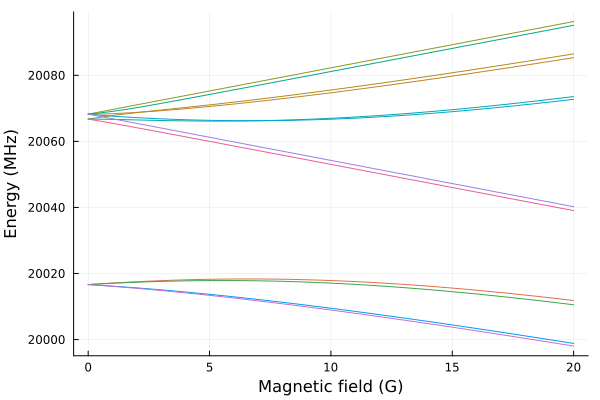

In [150]:
using Plots
plot_values = hcat(values(scan_values)...)'

plot(Bs, plot_values[:,5:16], legend=nothing)
plot!(
    xlabel="Magnetic field (G)",
    ylabel="Energy (MHz)"
)

## Evaluate transition dipole moments and set laser parameters

In [254]:
_, HX_N1_states = subspace(CaOH_000_N0to3_Hamiltonian.states, (N=1,))
states = [HX_N1_states; states_A_J12_caseB]
for state ∈ states
    state.E *= 1e6
end
;

In [255]:
d = zeros(ComplexF64, 16, 16, 3)
d_ge = zeros(ComplexF64, 12, 4, 3)
basis_tdms = get_tdms_two_bases(CaOH_000_N0to3_Hamiltonian.basis, basis_to_convert, TDM)
tdms_between_states!(d_ge, basis_tdms, HX_N1_states, states_A_J12_caseB)
d[1:12, 13:16, :] .= d_ge
;

In [256]:
J12_energy = energy(states[1])
J32_energy = energy(states[5])
A_energy = energy(states[13])

# CaOH MOT settings
I_load = 32 / 2 # mW/cm^2, or 33 mW per beam of 1/e² diameter = 1 cm (divide by 2 to account for power split between SR frequencies)
I_ramped = I_load / 11 # after ramping down the MOT
Isat = π * h * c * (Γ/2π) / (3λ^3)

# Parameters for laser addressing J=1/2
s_J12 = I_load / Isat
δJ12 = +2.0Γ
pol_J12 = σ⁺
ω_J12 = 2π * (A_energy - J12_energy) + δJ12

# Parameters for laser addressing J=3/2
s_J32 = I_load / Isat
δJ32 = +2.0Γ
pol_J32 = σ⁻
ω_J32 = 2π * (A_energy - J32_energy) + δJ32

# This function sets the polarization as a function of time; here it's just set to be constant
ϵ(ϵ1) = t -> ϵ1

ϵ1 = ϵ(rotate_pol(pol_J12, +x̂)); laser1 = Field(+x̂, ϵ1, ω_J12, s_J12)
ϵ2 = ϵ(rotate_pol(pol_J12, -x̂)); laser2 = Field(-x̂, ϵ2, ω_J12, s_J12)
ϵ3 = ϵ(rotate_pol(pol_J12, +ŷ)); laser3 = Field(+ŷ, ϵ3, ω_J12, s_J12)
ϵ4 = ϵ(rotate_pol(pol_J12, -ŷ)); laser4 = Field(-ŷ, ϵ4, ω_J12, s_J12)
ϵ5 = ϵ(rotate_pol(pol_J12, +ẑ)); laser5 = Field(+ẑ, ϵ5, ω_J12, s_J12)
ϵ6 = ϵ(rotate_pol(pol_J12, -ẑ)); laser6 = Field(-ẑ, ϵ6, ω_J12, s_J12)
lasers_J12 = [laser1, laser2, laser3, laser4, laser5, laser6]

ϵ7  = ϵ(rotate_pol(pol_J32, +x̂)); laser7  = Field(+x̂, ϵ7,  ω_J32, s_J32)
ϵ8  = ϵ(rotate_pol(pol_J32, -x̂)); laser8  = Field(-x̂, ϵ8,  ω_J32, s_J32)
ϵ9  = ϵ(rotate_pol(pol_J32, +ŷ)); laser9  = Field(+ŷ, ϵ9,  ω_J32, s_J32)
ϵ10 = ϵ(rotate_pol(pol_J32, -ŷ)); laser10 = Field(-ŷ, ϵ10, ω_J32, s_J32)
ϵ11 = ϵ(rotate_pol(pol_J32, +ẑ)); laser11 = Field(+ẑ, ϵ11, ω_J32, s_J32)
ϵ12 = ϵ(rotate_pol(pol_J32, -ẑ)); laser12 = Field(-ẑ, ϵ12, ω_J32, s_J32)
lasers_J32 = [laser7, laser8, laser9, laser10, laser11, laser12]

lasers = [lasers_J12; lasers_J32]
;

In [257]:
# Set initial conditions for the OBE solver
particle = Particle()

ρ0 = zeros(ComplexF64, length(states), length(states)) 
ρ0[1,1] = 1.0

freq_res = 1e-1
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res)

p.v = (0., 0., 5.) ./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)
;

In [258]:
t_end = 10p.period+1
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [259]:
prob.p.force_last_period = (0, 0, 0)
cb = PeriodicCallback(reset_force!, p.period)
@time sol = DifferentialEquations.solve(prob, DP5(), callback=cb, abstol=1e-6)
;

  7.565343 seconds (15.63 M allocations: 1.829 GiB, 3.98% gc time, 99.61% compilation time)


In [260]:
sol.t[end], t_end

(188.49555921538757, 629.3185307179587)

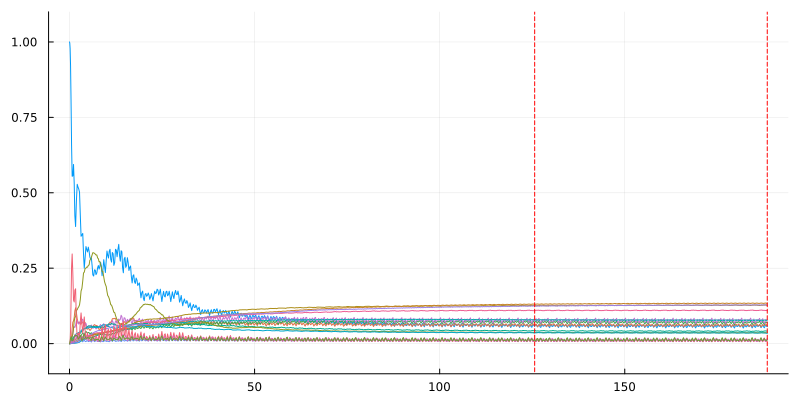

In [261]:
using Plots
plot_us = sol.u
plot_ts = sol.t

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

In [263]:
prob.p.force_last_period * (1e-3 * ħ * k * Γ / m)

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 0.004650844303636654
 0.000325726726396064
 1.9593069905340947

## Scan the force versus velocity

In [264]:
function prob_func!(prob, scan_values, i)
    # Update velocity and position
    prob.p.v .= (0, 0, scan_values.v[i])
    prob.p.v .= round_vel(prob.p.v, prob.p.freq_res)    
    prob.p.r0 .= rand(uniform_dist, 3)
    return prob
end
function param_func(prob, scan_values, i)
    return scan_values.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    f_proj = (f ⋅ p.v) / norm(p.v)
    return f_proj
end
;

In [265]:
freq_res = 1e-1
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 100p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false)

n_samples = 100

vs = repeat(0:0.5:5, n_samples) ./ (Γ / k)

scan_values = (v = vs,)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03

  3.090196 seconds (175.91 k allocations: 124.344 MiB)


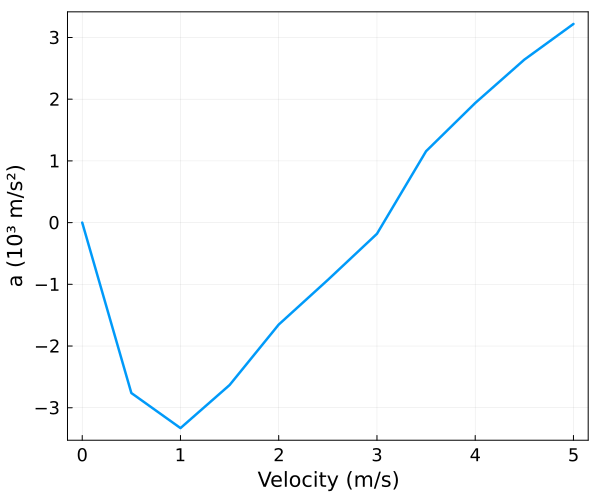

In [268]:
@time scan_params, forces = force_scan(prob, scan_values, prob_func!, param_func, output_func);
vs, averaged_forces_velocity = average_forces(scan_params, forces); averaged_forces_velocity[1] = 0.0
plot(vs .* (Γ / k), (1e-3 * ħ * k * Γ / m) .* averaged_forces_velocity,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    legend=nothing,
    size=(600,500)
    )